## Setup

In [126]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import pandas as pd
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot the figures
import matplotlib as mlp 
import matplotlib.pyplot as plt
mlp.rc('axes', labelsize=14)
mlp.rc('xtick', labelsize=12)
mlp.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "../"
IMAGES_PATH = "images"
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save the figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, figure=None):
    path = os.path.join(IMAGES_PATH, (fig_id + "." + fig_extension))
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()

    if figure is None:
        plt.savefig(path, format=fig_extension, dpi=resolution)
    else:
        figure.savefig(path, format=fig_extension, dpi=resolution)


## Get the  data

In [127]:
DATASETS_PATH = os.path.join(PROJECT_ROOT_DIR, 'datasets')
os.makedirs(DATASETS_PATH, exist_ok=True)

DATASET_NAME = 'dados 5-2.txt'

# columns names for the dataset
columns=['Distance','RSSI']

def load_data(data_path = DATASETS_PATH, dataset_name= DATASET_NAME, columns_names=columns):
    txt_path = os.path.join(data_path, dataset_name)
    return pd.read_table(txt_path, names=columns)

# read the dataset
data_5_2_Ghz = load_data(data_path=DATASETS_PATH, dataset_name=DATASET_NAME, columns_names=columns)
data_5_2_Ghz.head()
data_5_2_Ghz['Distance'] = np.log10(data_5_2_Ghz['Distance'])

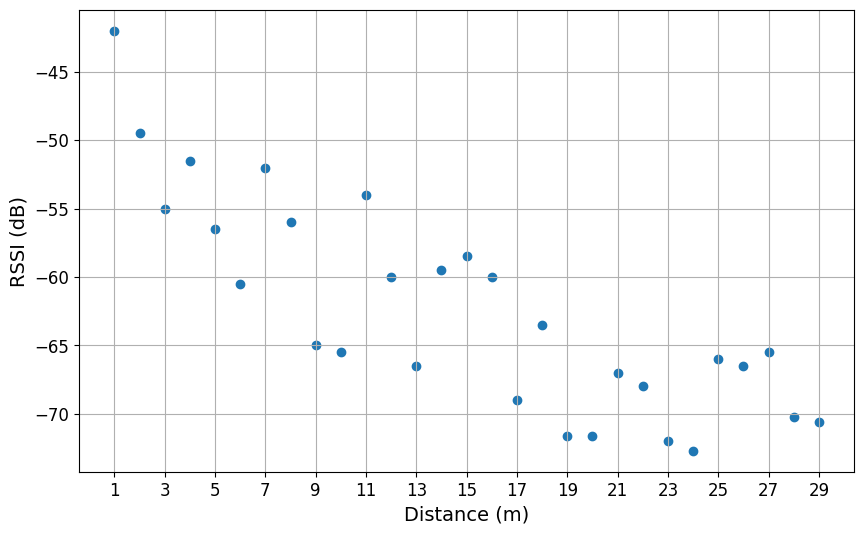

In [128]:
# Show the RSSI behavior in function of the distance
plt.figure(figsize=(10,6))
plt.scatter(10**data_5_2_Ghz['Distance'], data_5_2_Ghz['RSSI'], label='2.4 GHz')
plt.ylabel('RSSI (dB)')
plt.xlabel('Distance (m)')
plt.xticks(np.arange(1,30,2))
plt.grid()
plt.show()

## Split the data

In [129]:
# Split the data in 3 distances (near, medium, far)
near_data = data_5_2_Ghz[:10]
medium_data = data_5_2_Ghz[10:20]
far_data = data_5_2_Ghz[20:30]

## Optimized Path Loss Equation

In [130]:
# Function to calculate the RSSI using the Optimized Path Loss Equation
def calculate_rssi_with_optimized_path_loss_function(frequency, d):

    # Transmit power
    Pt = 10 * np.log10(250) + 5 + 1
    # Reference distance
    d0 = 1

    # Free-space path loss model
    Ao = 32.44+20*np.log10(d0/1000)+20*np.log10(frequency)

    # Distances
    d = 10**(d)

    # Optimized coefficients
    n = 1.849654136491729
    k = 25.764025097163724

    # Optimized Path Loss
    L = Ao + 10*n*np.log10(d/d0) + k

    # Received Power According to the Optimized Path Loss
    Pr = Pt - L
    
    return Pr

## Load the Trained Models

In [131]:
import joblib

# Loads the trained models
lin_reg = joblib.load('models/lin_reg.pkl')
lasso_reg_best = joblib.load('models/lasso_reg_best.pkl')
tree_reg_best = joblib.load('models/tree_reg_best.pkl')
forest_reg_best = joblib.load('models/forest_reg_best.pkl')

## Analyzing the Metrics in the Split datas

In [132]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

### Function to evaluate the models

In [133]:
# Plot the R2

def plot_r2(y_test, model_prediction, model_name, color='blue'):
    
    min_rssi_axis = min(y_test)-15
    max_rssi_axis = max(y_test)+15

    # Values of the RSSI to create the line of the R2=1 which is the ideal value
    rssi_values = np.linspace(min_rssi_axis, max_rssi_axis, 30)
    
    figure = plt.figure(figsize=(10,6))
    plt.scatter(y_test, model_prediction, marker='o', s=30, color=color, label=model_name)
    plt.plot(rssi_values, rssi_values, color='black', linestyle='--', label=r'$R^2=1$ (Caso ideal)')
    plt.xlabel('RSSI real', fontsize=15)
    plt.ylabel('RSSI previsto', fontsize=15)
    plt.legend(loc='best', fontsize=13)
    plt.xlim(min_rssi_axis, max_rssi_axis)
    plt.ylim(min_rssi_axis, max_rssi_axis)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid()
    plt.show()

    return figure

In [134]:
# Function to save the metrics of the models and path loss optimized equation in the test set
def save_metrics(lin_reg_rmse, lin_reg_mae, lin_reg_r2,
                 tree_reg_rmse, tree_reg_mae, tree_reg_r2,
                 forest_reg_rmse, forest_reg_mae, forest_reg_r2,
                 lasso_reg_rmse, lasso_reg_mae, lasso_reg_r2,
                 path_loss_opt_rmse, path_loss_opt_mae, path_loss_opt_r2,
                 filename='models_metrics_in_test_set.xlsx'):
    
    # Creates the tables folder
    os.makedirs('tables', exist_ok=True)

    METRICS_PATH = os.path.join('tables', filename)
    
    # Creates a dictionary with the metrics
    data = {
        'Model': ['Linear', 'Decision Tree', 'Random Forest', 'Lasso', 'Optimized Equation'],
        'RMSE': [lin_reg_rmse, tree_reg_rmse, forest_reg_rmse, lasso_reg_rmse, path_loss_opt_rmse],
        'MAE': [lin_reg_mae, tree_reg_mae, forest_reg_mae, lasso_reg_mae, path_loss_opt_mae],
        'R2': [lin_reg_r2, tree_reg_r2, forest_reg_r2, lasso_reg_r2, path_loss_opt_r2]
    }

    # Creates a dataframe
    df_metrics = pd.DataFrame(data)

    # Saves the dataframe in a excel file
    df_metrics.to_excel(METRICS_PATH, index=False)

    return df_metrics

In [135]:
# Function to evaluate the models and to save the metrics and figures
def evaluate_models(frequency, X_test, y_test, lin_reg_best, tree_reg_best, forest_reg_best, lasso_reg_best, distance, 
                    calculate_rssi_with_optimized_path_loss_function, plot_r2, save_metrics, save_fig):
    
    # Calculates the RSSI using the optimized path loss equation
    path_loss_opt_prediction = calculate_rssi_with_optimized_path_loss_function(frequency, X_test)

    # Predict RSSI in the given distance using the linear model
    lin_reg_prediction = lin_reg_best.predict(X_test)

    # Predict RSSI in the given distance using the tree model
    tree_reg_prediction = tree_reg_best.predict(X_test)

    # Predict RSSI in the given distance using the random forest model
    forest_reg_prediction = forest_reg_best.predict(X_test)

    # Predict RSSI in the given distance using the lasso model
    lasso_reg_prediction = lasso_reg_best.predict(X_test)

    # Prints and metrics for Optimized Path Loss Equation
    print(f'\n{"-"*10} Optimized Path Loss Equation Metrics - {distance} {"-"*10}')
    path_loss_opt_rmse = np.sqrt(root_mean_squared_error(y_test, path_loss_opt_prediction))
    path_loss_opt_mae = mean_absolute_error(y_test, path_loss_opt_prediction)
    path_loss_opt_r2 = r2_score(y_test, path_loss_opt_prediction)

    print(f'RMSE (Path Loss Optimized): {path_loss_opt_rmse}')
    print(f'MAE (Path Loss Optimized): {path_loss_opt_mae}')
    print(f'R2 (Path Loss Optimized): {path_loss_opt_r2}')

    # Prints and metrics for Linear Regression
    print(f'\n{"-"*10} Linear Regression Metrics - {distance} {"-"*10}')
    lin_reg_rmse = np.sqrt(root_mean_squared_error(y_test, lin_reg_prediction))
    lin_reg_mae = mean_absolute_error(y_test, lin_reg_prediction)
    lin_reg_r2 = r2_score(y_test, lin_reg_prediction)

    print(f'RMSE (Linear Regression): {lin_reg_rmse}')
    print(f'MAE (Linear Regression): {lin_reg_mae}')
    print(f'R2 (Linear Regression): {lin_reg_r2}')

    # Prints and metrics for Decision Tree
    print(f'\n{"-"*10} Decision Tree Metrics - {distance} {"-"*10}')
    tree_reg_rmse = np.sqrt(root_mean_squared_error(y_test, tree_reg_prediction))
    tree_reg_mae = mean_absolute_error(y_test, tree_reg_prediction)
    tree_reg_r2 = r2_score(y_test, tree_reg_prediction)

    print(f'RMSE (Decision Tree): {tree_reg_rmse}')
    print(f'MAE (Decision Tree): {tree_reg_mae}')
    print(f'R2 (Decision Tree): {tree_reg_r2}')

    # Prints and metrics for Random Forest
    print(f'\n{"-"*10} Random Forest Metrics - {distance} {"-"*10}')
    forest_reg_rmse = np.sqrt(root_mean_squared_error(y_test, forest_reg_prediction))
    forest_reg_mae = mean_absolute_error(y_test, forest_reg_prediction)
    forest_reg_r2 = r2_score(y_test, forest_reg_prediction)

    print(f'RMSE (Random Forest): {forest_reg_rmse}')
    print(f'MAE (Random Forest): {forest_reg_mae}')
    print(f'R2 (Random Forest): {forest_reg_r2}')

    # Prints and metrics for Lasso Regression
    print(f'\n{"-"*10} Lasso Regression Metrics - {distance} {"-"*10}')
    lasso_reg_rmse = np.sqrt(root_mean_squared_error(y_test, lasso_reg_prediction))
    lasso_reg_mae = mean_absolute_error(y_test, lasso_reg_prediction)
    lasso_reg_r2 = r2_score(y_test, lasso_reg_prediction)

    print(f'RMSE (Lasso Regression): {lasso_reg_rmse}')
    print(f'MAE (Lasso Regression): {lasso_reg_mae}')
    print(f'R2 (Lasso Regression): {lasso_reg_r2}')

    # Plot the R2 of the Optimized Path Loss
    fig_r2_path_loss_opt = plot_r2(y_test, path_loss_opt_prediction, f'Equação de Perda de Percurso Otimizada - {distance}', color='purple')
    # Plot the R2 of the Linear Model
    fig_r2_lin_reg = plot_r2(y_test, lin_reg_prediction, f'Regressão Linear - {distance}', color='orange')
    # Plot the R2 of the Decision Tree Model
    fig_r2_tree_reg = plot_r2(y_test, tree_reg_prediction, f'Árvore de Decisão - {distance}', color='blue')
    # Plot the R2 of the Random Forest Model
    fig_r2_forest_reg = plot_r2(y_test, forest_reg_prediction, f'Random Forest - {distance}', color='green')
    # Plot the R2 of the Lasso Regression Model
    fig_r2_lasso_reg = plot_r2(y_test, lasso_reg_prediction, f'Lasso - {distance}', color='red')

    # Save the figures
    save_fig(f'2-R2_Linear_Model_{distance}', fig_extension='png', resolution=300, figure=fig_r2_lin_reg)
    save_fig(f'3-R2_Decision_Tree_Model_{distance}', fig_extension='png', resolution=300, figure=fig_r2_tree_reg)
    save_fig(f'4-R2_Random_Forest_Model_{distance}', fig_extension='png', resolution=300, figure=fig_r2_forest_reg)
    save_fig(f'5-R2_Optimized_Path_Loss_{distance}', fig_extension='png', resolution=300, figure=fig_r2_path_loss_opt)
    save_fig(f'6-R2_Lasso_Model_{distance}', fig_extension='png', resolution=300, figure=fig_r2_lasso_reg)

    # Save the metrics
    df_metrics = save_metrics(lin_reg_rmse, lin_reg_mae, lin_reg_r2,
                              tree_reg_rmse, tree_reg_mae, tree_reg_r2,
                              forest_reg_rmse, forest_reg_mae, forest_reg_r2,
                              lasso_reg_rmse, lasso_reg_mae, lasso_reg_r2,
                              path_loss_opt_rmse, path_loss_opt_mae, path_loss_opt_r2,
                              filename=f'models_metrics_in_test_set_{distance}.xlsx')

    return df_metrics


### Near Distance

In [136]:
# Creates the feature and labels for the near distance datas
X_near = near_data.drop(['RSSI'],axis=1)
y_near = near_data['RSSI']


---------- Optimized Path Loss Equation Metrics - Próxima ----------
RMSE (Path Loss Optimized): 1.8824297957026193
MAE (Path Loss Optimized): 3.102060732992591
R2 (Path Loss Optimized): 0.7288118470835958

---------- Linear Regression Metrics - Próxima ----------
RMSE (Linear Regression): 2.0092933062496776
MAE (Linear Regression): 3.697934008444257
R2 (Linear Regression): 0.6479787268202521

---------- Decision Tree Metrics - Próxima ----------
RMSE (Decision Tree): 2.346660171585001
MAE (Decision Tree): 4.25
R2 (Decision Tree): 0.34506776092003677

---------- Random Forest Metrics - Próxima ----------
RMSE (Random Forest): 2.620917307452776
MAE (Random Forest): 5.407990651323987
R2 (Random Forest): -0.01908130499714722

---------- Lasso Regression Metrics - Próxima ----------
RMSE (Lasso Regression): 1.9902155566467798
MAE (Lasso Regression): 3.6189939928062103
R2 (Lasso Regression): 0.6611589444179398


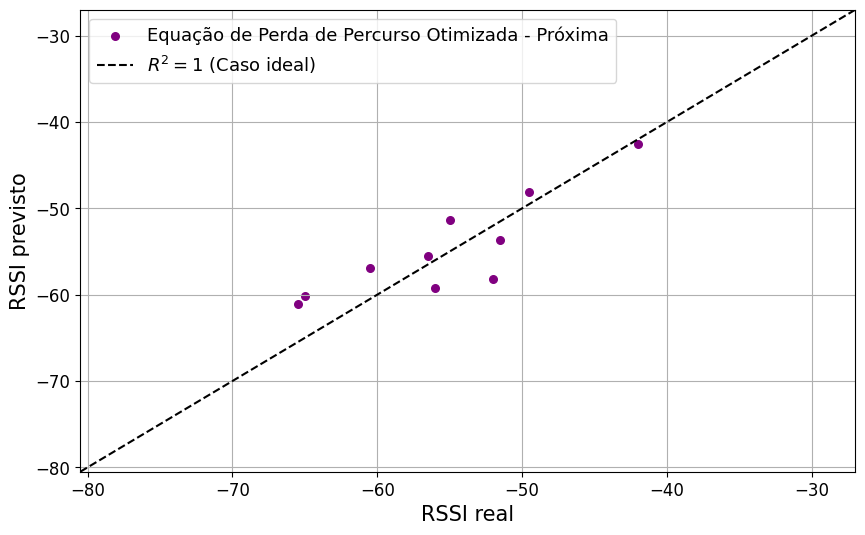

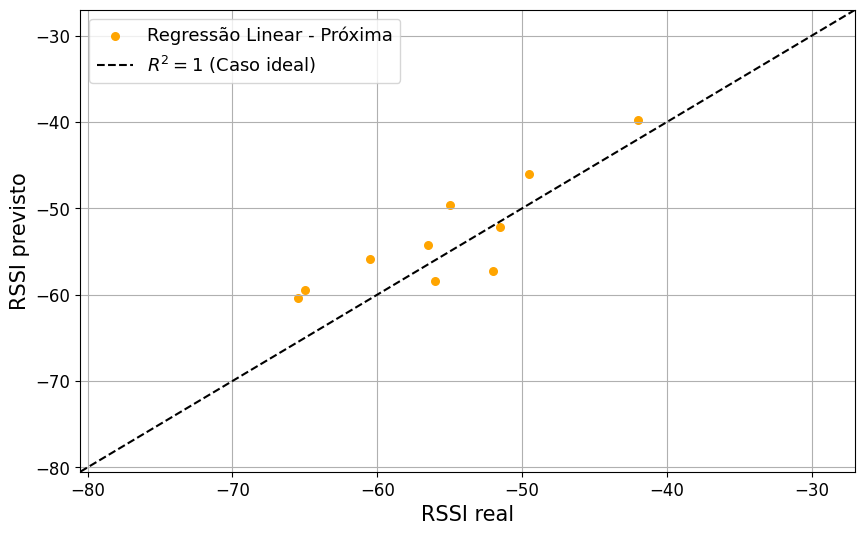

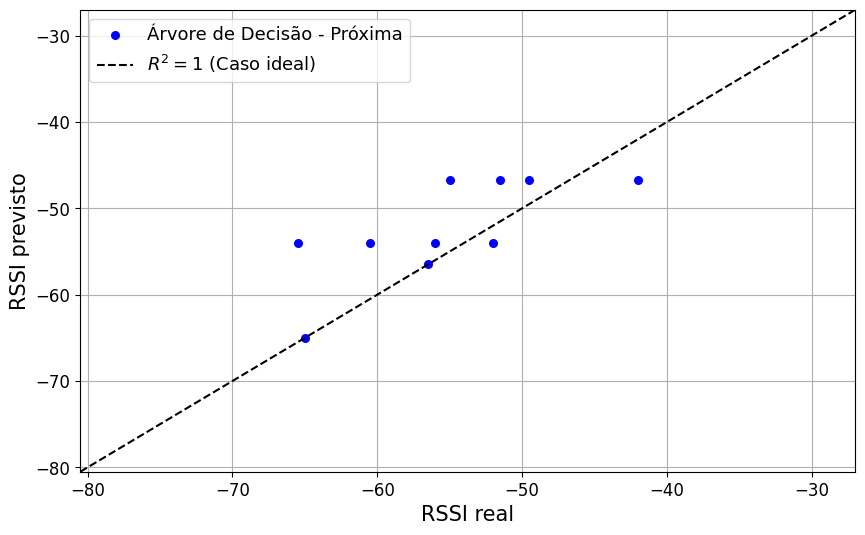

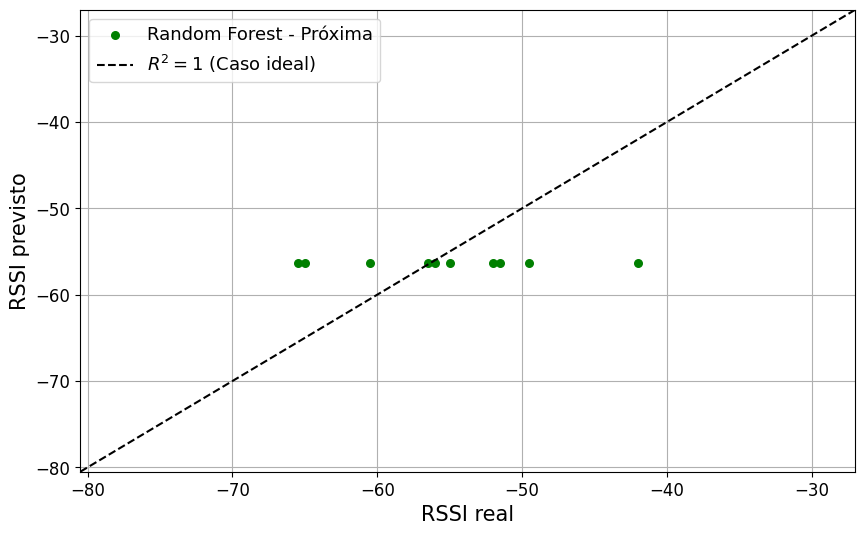

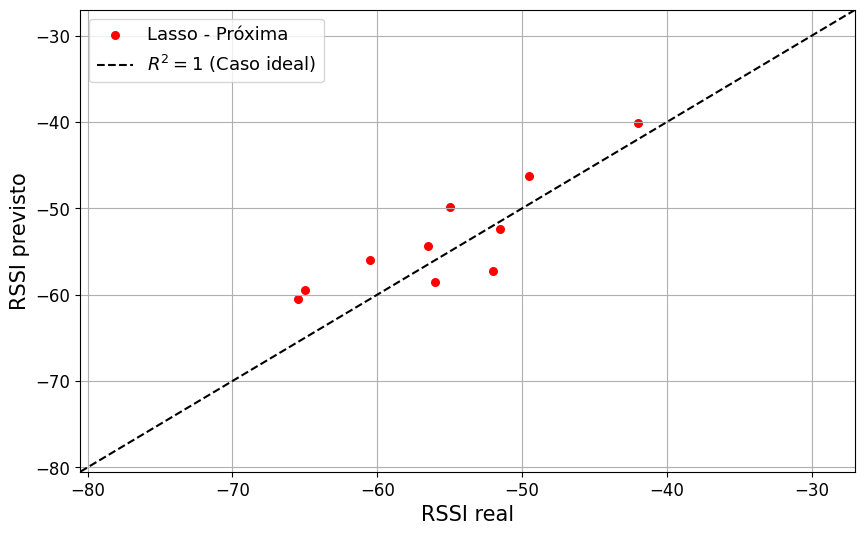

Saving figure 2-R2_Linear_Model_Próxima
Saving figure 3-R2_Decision_Tree_Model_Próxima
Saving figure 4-R2_Random_Forest_Model_Próxima
Saving figure 5-R2_Optimized_Path_Loss_Próxima
Saving figure 6-R2_Lasso_Model_Próxima


<Figure size 640x480 with 0 Axes>

In [137]:
# Distance type
distance = "Próxima"
# Frequency
frequency = 5200
df_metrics_near_distance = evaluate_models(frequency, X_near, y_near, lin_reg, tree_reg_best, forest_reg_best, lasso_reg_best, distance, calculate_rssi_with_optimized_path_loss_function, plot_r2, save_metrics, save_fig)

### Medium Distance

In [138]:
# Creates the feature and labels for the medium distance datas
X_medium = medium_data.drop(['RSSI'],axis=1)
y_medium = medium_data['RSSI']


---------- Optimized Path Loss Equation Metrics - Média ----------
RMSE (Path Loss Optimized): 2.70833051164591
MAE (Path Loss Optimized): 5.9000170882916025
R2 (Path Loss Optimized): -0.6496099883096833

---------- Linear Regression Metrics - Média ----------
RMSE (Linear Regression): 2.1462375981865236
MAE (Linear Regression): 4.355260184750831
R2 (Linear Regression): 0.3494422988044429

---------- Decision Tree Metrics - Média ----------
RMSE (Decision Tree): 1.8143340414165323
MAE (Decision Tree): 1.5599999999999994
R2 (Decision Tree): 0.6677663449392316

---------- Random Forest Metrics - Média ----------
RMSE (Random Forest): 1.9830392023925656
MAE (Random Forest): 3.2564544745378052
R2 (Random Forest): 0.5258673893986883

---------- Lasso Regression Metrics - Média ----------
RMSE (Lasso Regression): 2.1489874447368593
MAE (Lasso Regression): 4.363759581332761
R2 (Lasso Regression): 0.3461018021672989


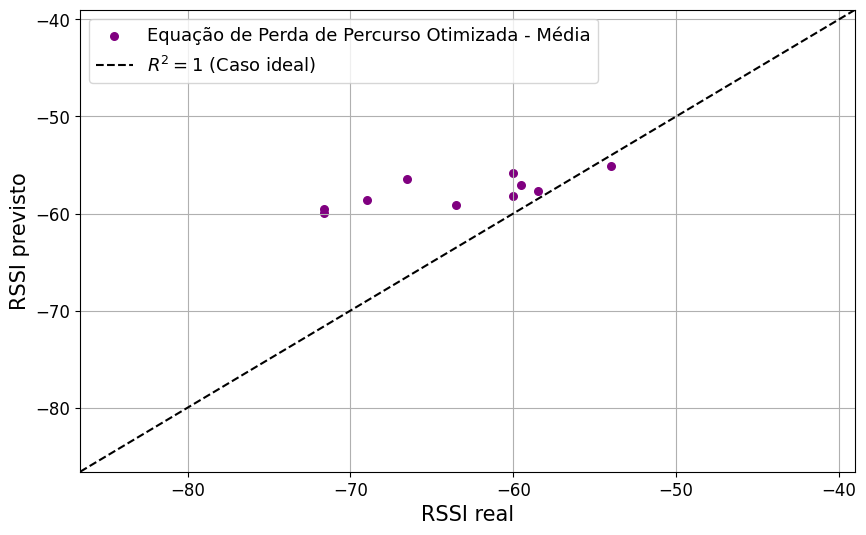

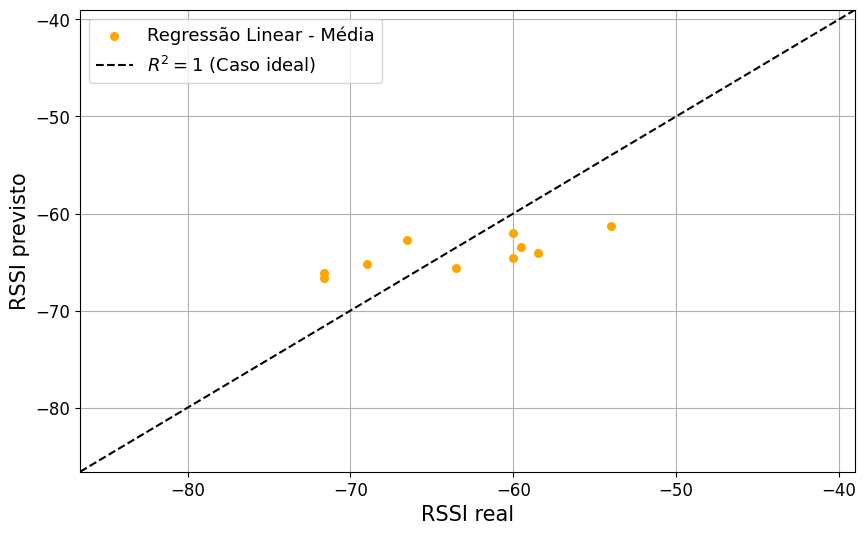

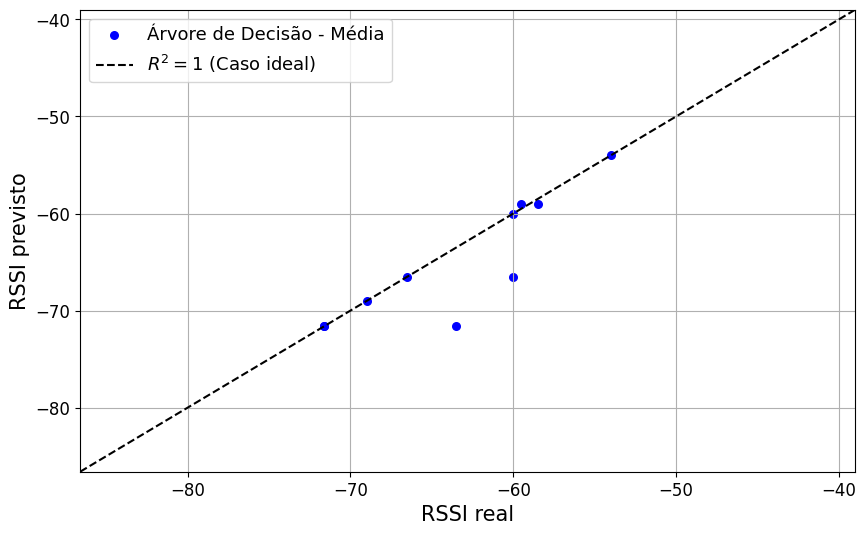

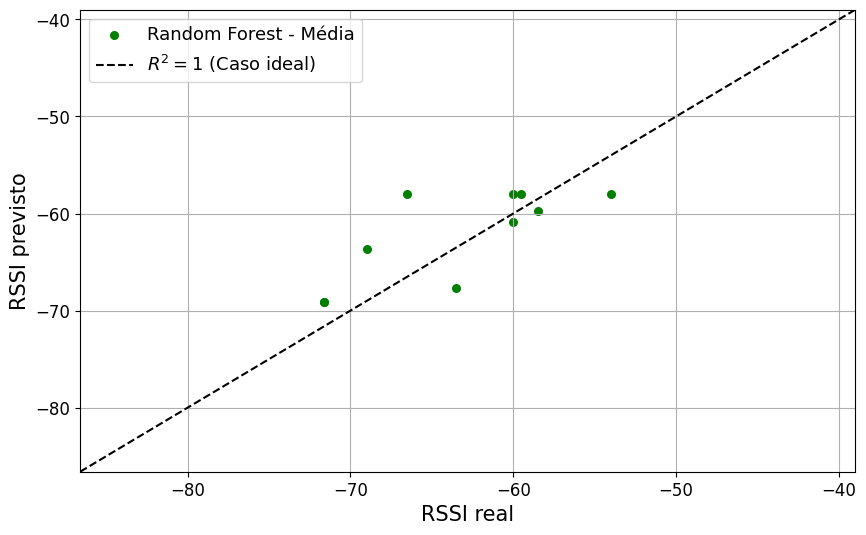

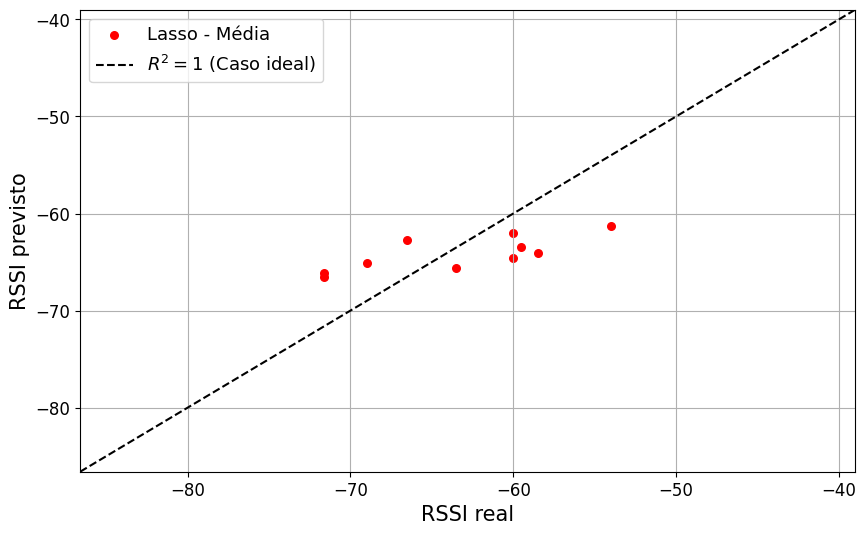

Saving figure 2-R2_Linear_Model_Média
Saving figure 3-R2_Decision_Tree_Model_Média
Saving figure 4-R2_Random_Forest_Model_Média
Saving figure 5-R2_Optimized_Path_Loss_Média
Saving figure 6-R2_Lasso_Model_Média


<Figure size 640x480 with 0 Axes>

In [139]:
# Distance type
distance = "Média"
# Frequency
frequency = 2412
df_metrics_near_distance = evaluate_models(frequency, X_medium, y_medium, lin_reg, tree_reg_best, forest_reg_best, lasso_reg_best, distance,calculate_rssi_with_optimized_path_loss_function, plot_r2, save_metrics, save_fig)

### Far Distance

In [140]:
# Creates the feature and labels for the far distance datas
X_far = far_data.drop(['RSSI'],axis=1)
y_far = far_data['RSSI']


---------- Optimized Path Loss Equation Metrics - Longa ----------
RMSE (Path Loss Optimized): 2.742688263120086
MAE (Path Loss Optimized): 7.036248823265784
R2 (Path Loss Optimized): -7.706135689685629

---------- Linear Regression Metrics - Longa ----------
RMSE (Linear Regression): 1.641478602184037
MAE (Linear Regression): 2.1437900417435207
R2 (Linear Regression): -0.11701895419969977

---------- Decision Tree Metrics - Longa ----------
RMSE (Decision Tree): 0.5699939866586008
MAE (Decision Tree): 0.28888888888888825
R2 (Decision Tree): 0.9837594499107245

---------- Random Forest Metrics - Longa ----------
RMSE (Random Forest): 1.6038057563134036
MAE (Random Forest): 2.395976929449153
R2 (Random Forest): -0.017950619533792844

---------- Lasso Regression Metrics - Longa ----------
RMSE (Lasso Regression): 1.6420404761280984
MAE (Lasso Regression): 2.157188276693006
R2 (Lasso Regression): -0.11854915061934412


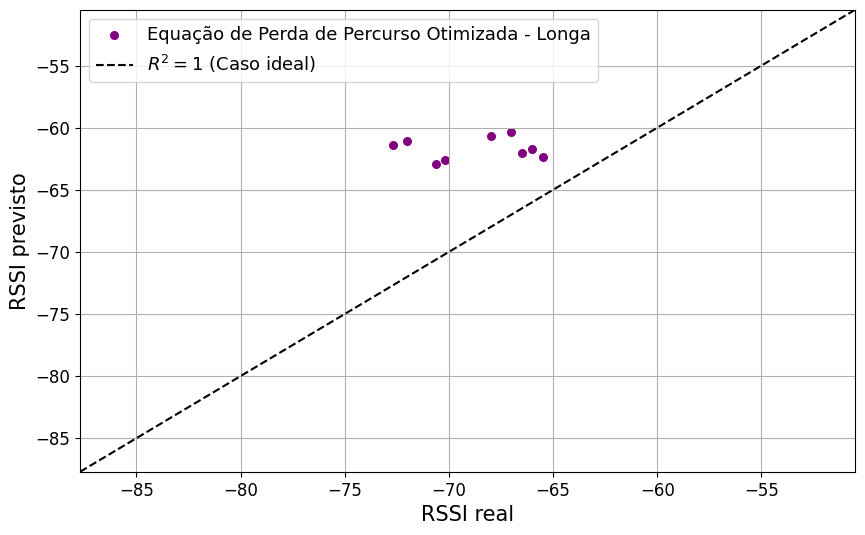

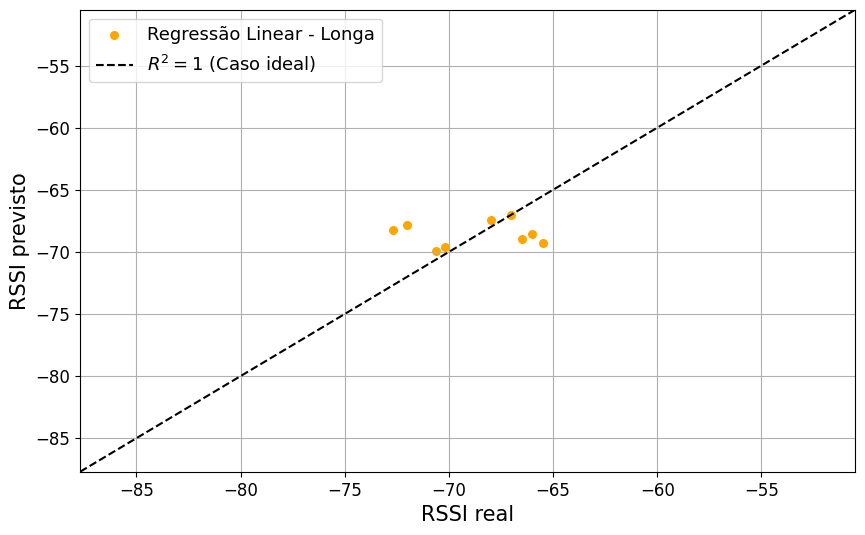

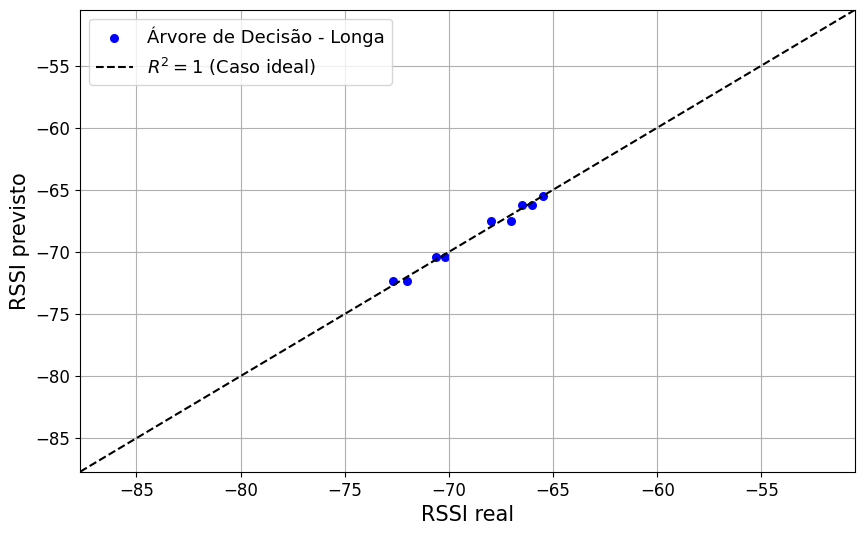

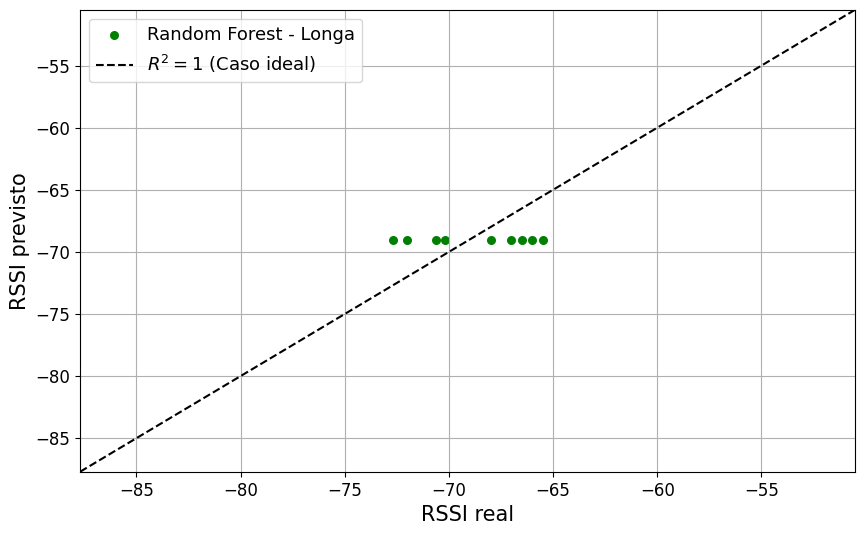

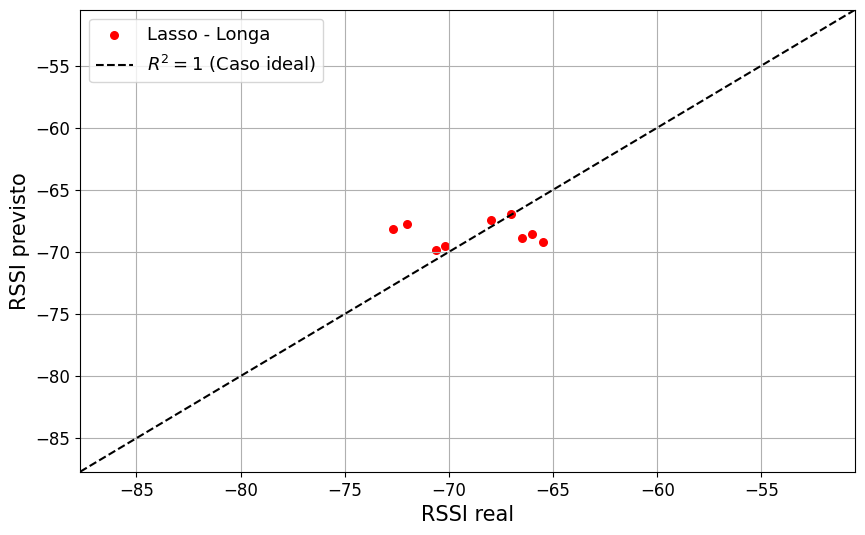

Saving figure 2-R2_Linear_Model_Longa
Saving figure 3-R2_Decision_Tree_Model_Longa
Saving figure 4-R2_Random_Forest_Model_Longa
Saving figure 5-R2_Optimized_Path_Loss_Longa
Saving figure 6-R2_Lasso_Model_Longa


<Figure size 640x480 with 0 Axes>

In [141]:
# Distance type
distance = "Longa"
# Frequency
frequency = 2412
df_metrics_near_distance = evaluate_models(frequency, X_far, y_far, lin_reg, tree_reg_best, forest_reg_best, lasso_reg_best, distance, calculate_rssi_with_optimized_path_loss_function, plot_r2, save_metrics, save_fig)

###  The Whole Dataset

In [142]:
# Creates the feature and labels for the far the whole dataset
X = data_5_2_Ghz.drop(['RSSI'], axis=1)
y = data_5_2_Ghz['RSSI']


---------- Optimized Path Loss Equation Metrics - Geral ----------
RMSE (Path Loss Optimized): 2.7701804578706777
MAE (Path Loss Optimized): 6.750750731468653
R2 (Path Loss Optimized): 0.0038893058932684133

---------- Linear Regression Metrics - Geral ----------
RMSE (Linear Regression): 1.9742018798551226
MAE (Linear Regression): 3.4422776657807783
R2 (Linear Regression): 0.7430541532575515

---------- Decision Tree Metrics - Geral ----------
RMSE (Decision Tree): 1.942103093942143
MAE (Decision Tree): 2.0931034482758615
R2 (Decision Tree): 0.7593618510503068

---------- Random Forest Metrics - Geral ----------
RMSE (Random Forest): 2.2054080360626536
MAE (Random Forest): 3.731318745643458
R2 (Random Forest): 0.5998423088205515

---------- Lasso Regression Metrics - Geral ----------
RMSE (Lasso Regression): 1.9686621237827693
MAE (Lasso Regression): 3.4221458700560956
R2 (Lasso Regression): 0.7459260727070747


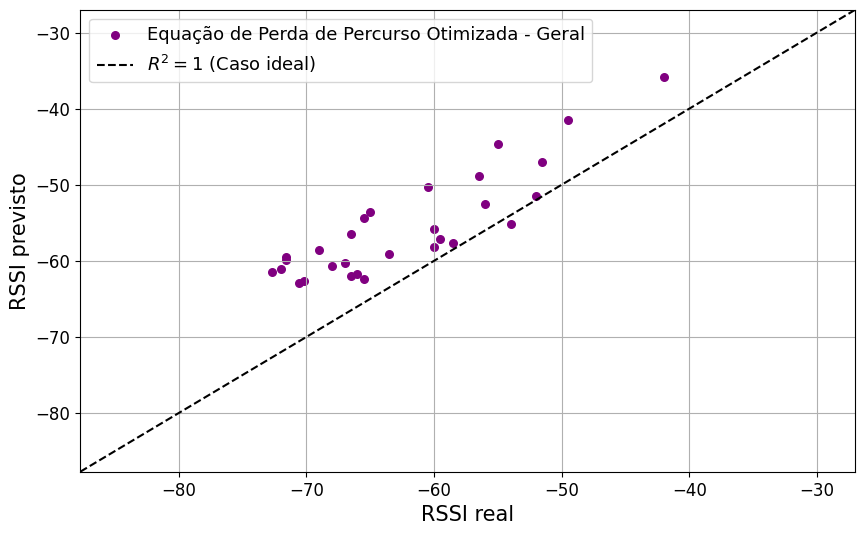

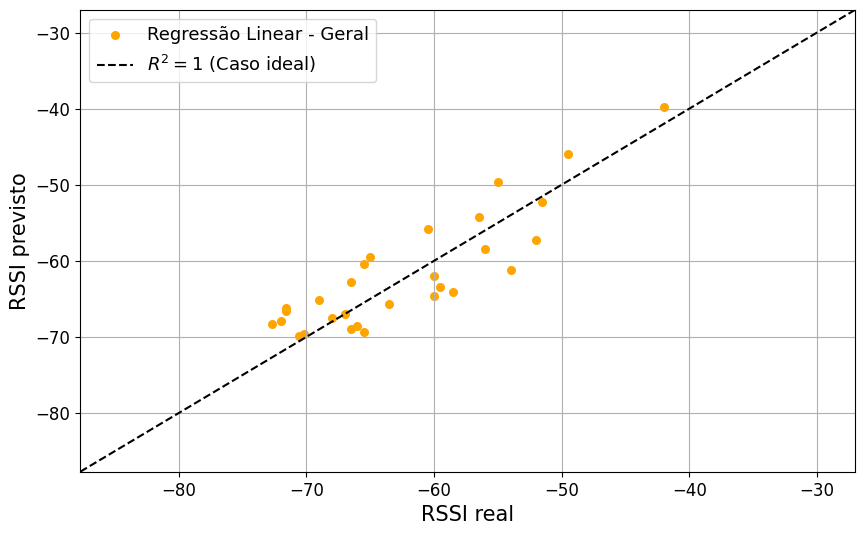

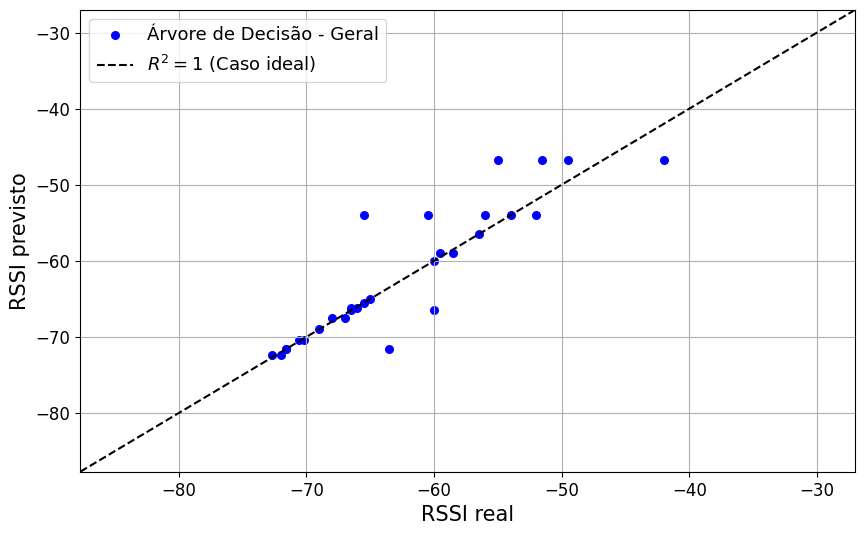

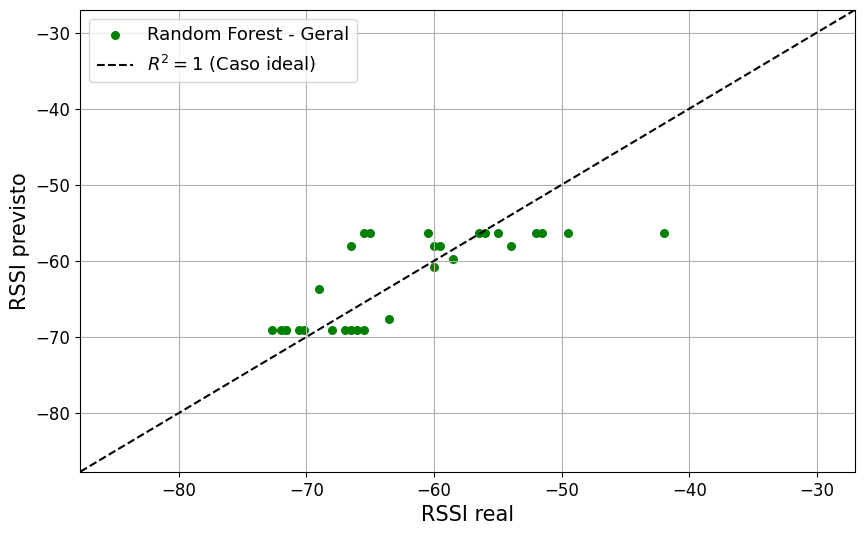

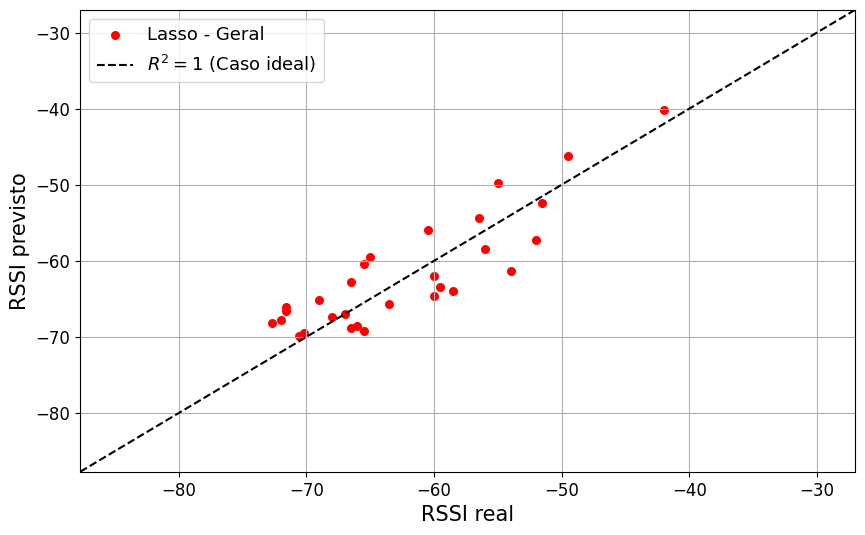

Saving figure 2-R2_Linear_Model_Geral
Saving figure 3-R2_Decision_Tree_Model_Geral
Saving figure 4-R2_Random_Forest_Model_Geral
Saving figure 5-R2_Optimized_Path_Loss_Geral
Saving figure 6-R2_Lasso_Model_Geral


<Figure size 640x480 with 0 Axes>

In [143]:
# Distance type
distance = "Geral"
# Frequency
frequency = 2412
df_metrics_near_distance = evaluate_models(frequency, X, y, lin_reg, tree_reg_best, forest_reg_best, lasso_reg_best, distance, calculate_rssi_with_optimized_path_loss_function, plot_r2, save_metrics, save_fig)

## RSSI x Distance

In [28]:
# Function to show the RSSI behavior by distance
def plot_rssi_values(rssi_real_values, distances_values, rssi_predicted, model, color='blue'):

    distances_values = 10**distances_values
    figure = plt.figure(figsize=(10,6))
    plt.scatter(distances_values, rssi_real_values, marker='o', color='black', label='RSSI Real')
    plt.plot(distances_values, rssi_predicted, marker = '*', color=color, label=f'{model}')
    plt.xlabel('Distância (m)', fontsize=15)
    plt.ylabel('RSSI (dB)', fontsize=15)
    plt.legend(loc='best', fontsize=15)
    plt.xticks(np.arange(1,30,2))
    plt.grid()
    plt.show()

    return figure

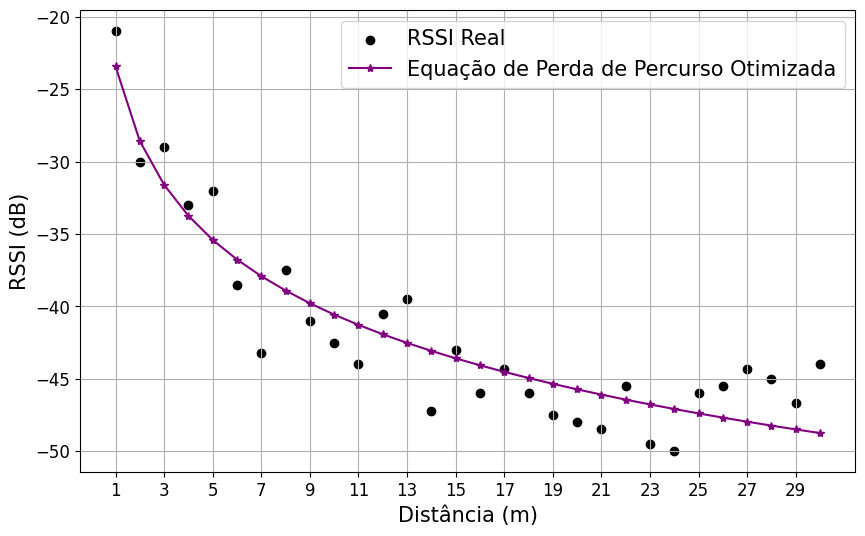

In [66]:
# Prediction in the whole dataset using the Path Loss Optimized Equation
path_loss_opt_prediction = calculate_rssi_with_optimized_path_loss_function(frequency, X)
path_loss_opt_overall_figure = plot_rssi_values(y, X['Distance'], path_loss_opt_prediction, 'Equação de Perda de Percurso Otimizada', color='purple')

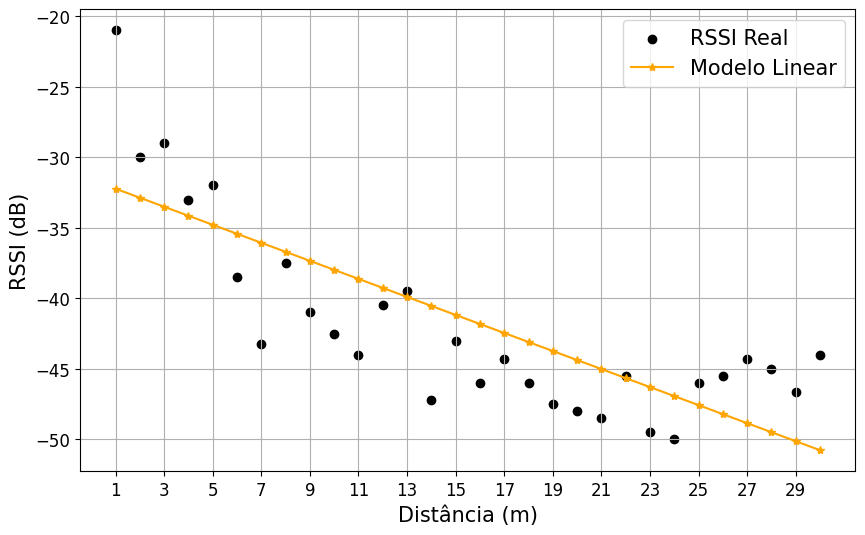

In [67]:
# Prediction in the whole dataset using Linear model
lin_reg_prediction = lin_reg.predict(X)
lin_reg_overall_figure = plot_rssi_values(y, X['Distance'], lin_reg_prediction, 'Modelo Linear', color='orange')

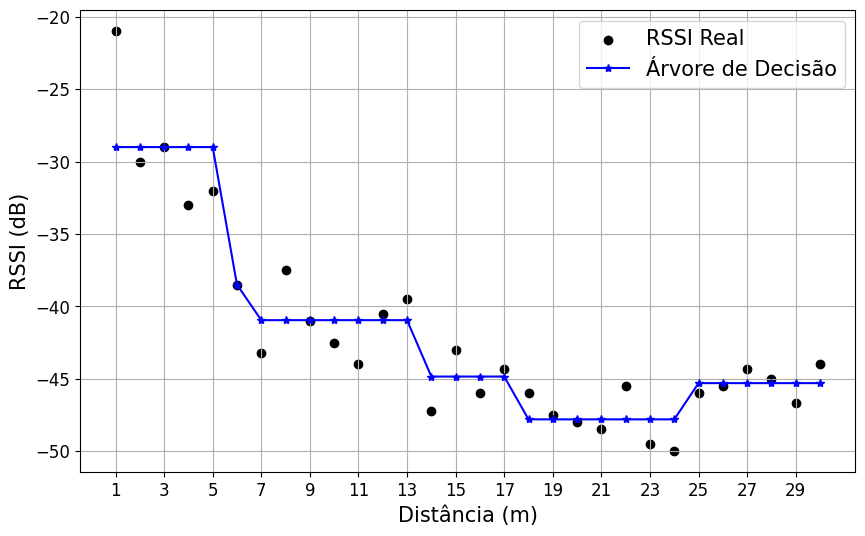

In [68]:
# Prediction in the whole dataset using Tree Model
tree_reg_prediction = tree_reg_best.predict(X)
tree_reg_overall_figure = plot_rssi_values(y, X['Distance'], tree_reg_prediction, 'Árvore de Decisão', color='blue')

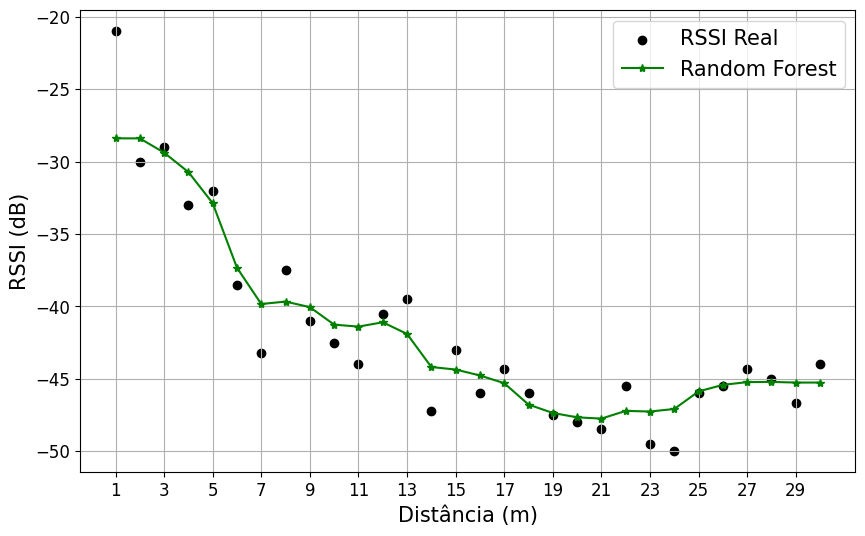

In [72]:
# Prediction in the whole dataset using Random Forest Model
forest_reg_prediction = forest_reg_best.predict(X)
forest_reg_overall_figure = plot_rssi_values(y, X['Distance'], forest_reg_prediction, 'Random Forest', color='green')

In [73]:
# Saving the figures of the RSSIxDistance
save_fig('6-RSSIxDistance_Path_Loss', fig_extension='png', resolution=300, figure=path_loss_opt_overall_figure)
save_fig('6-RSSIxDistance_Linear_Model', fig_extension='png', resolution=300, figure=lin_reg_overall_figure)
save_fig('6-RSSIxDistance_Decision_Tree_Model', fig_extension='png', resolution=300, figure=tree_reg_overall_figure)
save_fig('6-RSSIxDistance_Random_Forest_Model', fig_extension='png', resolution=300, figure=forest_reg_overall_figure)

Saving figure 6-RSSIxDistance_Path_Loss
Saving figure 6-RSSIxDistance_Linear_Model
Saving figure 6-RSSIxDistance_Decision_Tree_Model
Saving figure 6-RSSIxDistance_Random_Forest_Model


<Figure size 640x480 with 0 Axes>